In [1]:
from dask.distributed import Client, LocalCluster
client = Client(n_workers=10,threads_per_worker=100,processes=True)
client

/home/joedhsu/.conda/envs/proj1_tropdiag/lib/python3.8/site-packages/distributed/node.py:151: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 40211 instead
  warnings.warn(


Client Scheduler: tcp://127.0.0.1:33761 Dashboard: http://127.0.0.1:40211/status,Cluster Workers: 10 Cores: 1000 Memory: 67.54 GB


In [2]:
import xarray as xr
import numpy as np

In [3]:
# 0-360
lon_lim = [0,360]
lat_lim = [-90,90]

In [4]:
import importlib
import io_model
importlib.reload(io_model)
from io_model import E3SM_io_HIST2000_branched_all
ds_original = E3SM_io_HIST2000_branched_all(lon_lim,
                                           lat_lim,
                                           varlist=['FSNT','FLNT'],
                                           case='original').compute()


In [5]:
from io_model import E3SM_io_HIST2000_branched_all
ds_coare35 = E3SM_io_HIST2000_branched_all(lon_lim,
                                           lat_lim,
                                           varlist=['FSNT','FLNT','area'],
                                           case='coare35_year1').compute()


In [7]:
from io_model import E3SM_io_HIST2000_branched_all
ds_coare35_1_5 = E3SM_io_HIST2000_branched_all(lon_lim,
                                           lat_lim,
                                           varlist=['FSNT','FLNT','area'],
                                           case='coare35_year1-5').compute()


In [9]:
ds_coare35 = xr.concat([ds_coare35,ds_coare35_1_5],dim='time')

In [10]:
from memory import used_memory
used_memory()

used 5074.316406 MB


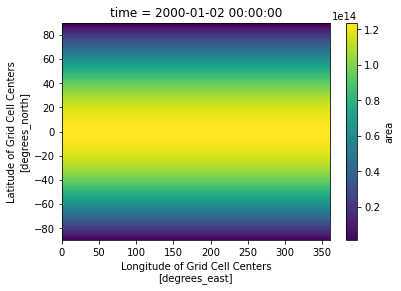

In [11]:
arad = np.float64(6.371E8) #cm
(ds_coare35.area.isel(time=0)*arad**2).plot()

In [12]:
da_area = ds_coare35.area.isel(time=0)*arad**2*1e-4 # cm^2 to m^2

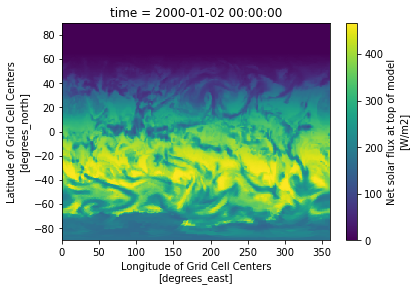

In [13]:
ds_coare35.FSNT.isel(time=0).plot()

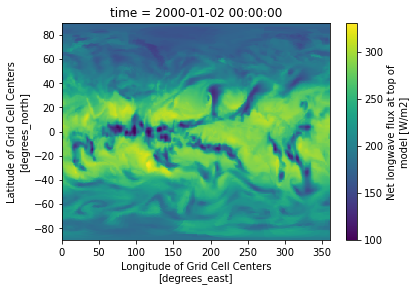

In [14]:
ds_coare35.FLNT.isel(time=0).plot()

In [15]:
da_area.sum(dim=['lon','lat'])

<xarray.DataArray 'area' ()>
array(5.10064472e+14)
Coordinates:
    time     object 2000-01-02 00:00:00

In [16]:
# Net solar flux at top of model = FSNT
# Net longwave flux at top of model = FLNT
da_orig_glo_areaweight_fsnt = ((ds_original.FSNT)*da_area).sum(dim=['lon','lat'])/da_area.sum(dim=['lon','lat'])
da_orig_glo_areaweight_flnt = ((ds_original.FLNT)*da_area).sum(dim=['lon','lat'])/da_area.sum(dim=['lon','lat'])

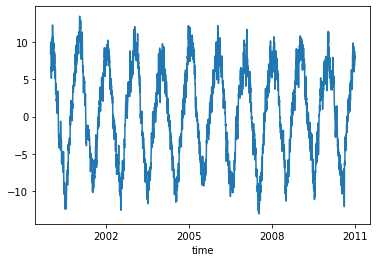

In [17]:
# da_orig_glo_areaweight_fsnt.plot()
# da_orig_glo_areaweight_flnt.plot()
(da_orig_glo_areaweight_fsnt-da_orig_glo_areaweight_flnt).plot()

In [18]:
# Net solar flux at top of model = FSNT
# Net longwave flux at top of model = FLNT
da_orig_glo_areaweight_fsnt = ((ds_original.FSNT)*da_area).sum(dim=['lon','lat'])/1e15
da_orig_glo_areaweight_flnt = ((ds_original.FLNT)*da_area).sum(dim=['lon','lat'])/1e15

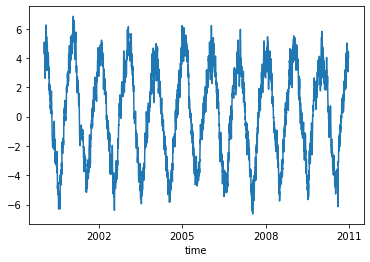

In [19]:
# da_orig_glo_areaweight_fsnt.plot()
# da_orig_glo_areaweight_flnt.plot()
(da_orig_glo_areaweight_fsnt-da_orig_glo_areaweight_flnt).plot()

In [20]:
da_coare35_glo_areaweight_net = ((ds_coare35.FSNT-ds_coare35.FLNT)*da_area).sum(dim=['lon','lat'])/da_area.sum(dim=['lon','lat'])

In [21]:
da_orig_glo_areaweight_net = ((ds_original.FSNT-ds_original.FLNT)*da_area).sum(dim=['lon','lat'])/da_area.sum(dim=['lon','lat'])

In [24]:
global_mean_energy = xr.Dataset()
global_mean_energy['original'] = da_orig_glo_areaweight_net.isel(time=np.arange(0,365*5))
global_mean_energy['original'] = global_mean_energy['original']-global_mean_energy['original'].mean(dim='time')
global_mean_energy['COARE3.5'] = da_coare35_glo_areaweight_net
global_mean_energy['COARE3.5'] = global_mean_energy['COARE3.5']-global_mean_energy['COARE3.5'].mean(dim='time')
global_mean_energy['COARE3.5-original'] = global_mean_energy['COARE3.5']-global_mean_energy['original']

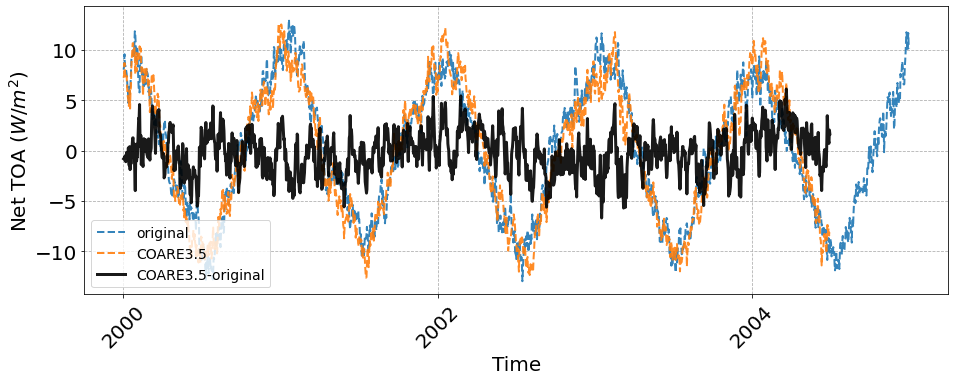

In [28]:
import matplotlib.pyplot as plt
import cftime
#### plotting
fig = plt.figure(1)
ax1 = fig.add_axes([0,0,2,1])
ax1color = 'k'

modelname = ['original','COARE3.5','COARE3.5-original']
model_legend_name = ['original','COARE3.5','COARE3.5-original']
colors = ['C0','C1','k']
linestyles = ['--','--','-']
linewidths = [2,2,3]

for nmodel,model in enumerate(modelname):
    global_mean_energy[model].plot(ax=ax1,
              label=model_legend_name[nmodel],
              linewidth=linewidths[nmodel],
              linestyle=linestyles[nmodel],
              color=colors[nmodel],
              alpha=0.9)

# for nmodel,model in enumerate(modelname):
#     ax1.plot(global_mean_energy[model].values,
#               label=model_legend_name[nmodel],
#               linewidth=linewidths[nmodel],
#               linestyle=linestyles[nmodel],
#               color=colors[nmodel],
#               alpha=0.9)

# arglist = []
# for month in range(1,13):
#     (arglist.append(np.argwhere(global_mean_energy['original'].time.values
#                                 ==cftime.DatetimeNoLeap(2000, month, 2, 0, 0, 0, 0))[0][0])
#     )
# monlabellist = global_mean_energy['original']['time.month'].values[arglist]
# yearlabellist = global_mean_energy['original']['time.year'].values[arglist]
# labellist = ['%0.4i-%0.2i'%(yearlabellist[i],monlabellist[i]) for i in range(len(arglist))]

#### setting the plotting format
ax1.set_ylabel('Net TOA ($W/m^2$)',{'size':'20'},color='k')
ax1.set_xlabel('Time',{'size':'20'})
ax1.tick_params(axis='y',labelsize=20,labelcolor='k')
ax1.tick_params(axis='x',labelsize=20,labelcolor='k',rotation=45)
# ax1.set_xticks(arglist)
# ax1.set_xticklabels(labellist)

ax1.set_title("",{'size':'24'},pad=24)
ax1.legend(loc='lower left',fontsize=14)
ax1.grid(linestyle='dashed')

# fig.savefig('../figure/figure_sup_oni2.pdf', dpi=300, facecolor='w', edgecolor='w',
#                 orientation='portrait', papertype=None, format=None,
#                 transparent=False, bbox_inches="tight", pad_inches=None,
#                 frameon=None)

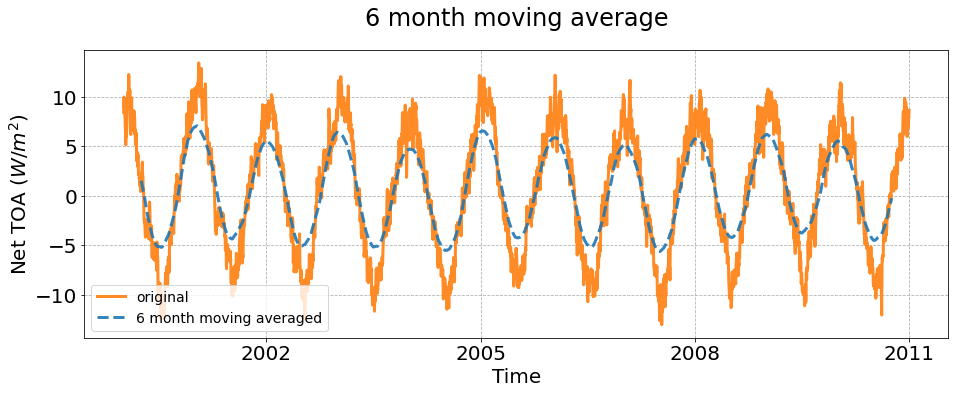

In [29]:
import cftime
import matplotlib.pyplot as plt

#### plotting
fig = plt.figure(1)
ax1 = fig.add_axes([0,0,2,1])
ax1color = 'k'

modelname = ['original']
model_legend_name = ['original']
colors = ['C0']
linestyles = ['-']
linewidths = [3]

(da_orig_glo_areaweight_net
                    .plot(ax=ax1,
                          label='original',
                          linewidth=3,
                          linestyle='-',
                          color='C1',
                          alpha=0.9)
)
(da_orig_glo_areaweight_net
                    .rolling(time=180, min_periods=180,center=True).mean()
                    .plot(ax=ax1,
                          label='6 month moving averaged',
                          linewidth=3,
                          linestyle='--',
                          color='C0',
                          alpha=0.9)
)


    

#### setting the plotting format
ax1.set_ylabel('Net TOA ($W/m^2$)',{'size':'20'},color='k')
ax1.set_xlabel('Time',{'size':'20'})
ax1.tick_params(axis='y',labelsize=20,labelcolor='k')
ax1.tick_params(axis='x',labelsize=20,labelcolor='k',rotation=0)
ax1.set_title("6 month moving average",{'size':'24'},pad=24)
ax1.legend(loc='lower left',fontsize=14)
ax1.grid(linestyle='dashed')


# fig.savefig('../figure/figure_sup_oni2.pdf', dpi=300, facecolor='w', edgecolor='w',
#                 orientation='portrait', papertype=None, format=None,
#                 transparent=False, bbox_inches="tight", pad_inches=None,
#                 frameon=None)

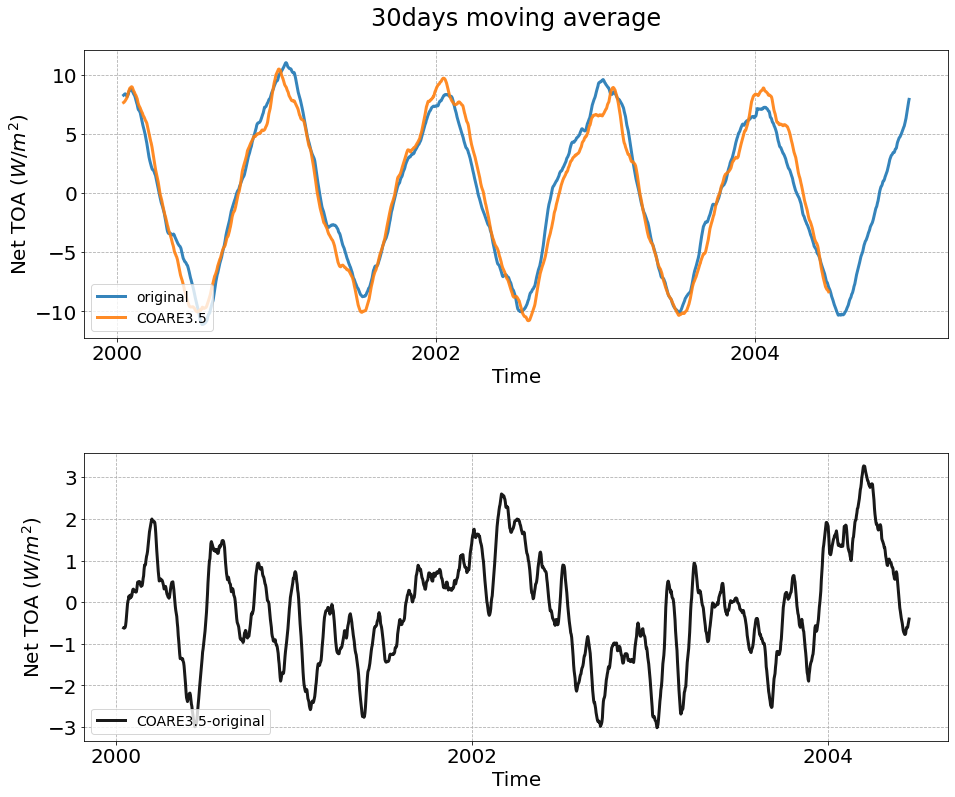

In [30]:
import cftime
import matplotlib.pyplot as plt

#### plotting
fig = plt.figure(1)
ax1 = fig.add_axes([0,0,2,1])
ax1color = 'k'

modelname = ['original','COARE3.5']
model_legend_name = ['original','COARE3.5','COARE3.5-original']
colors = ['C0','C1','k']
linestyles = ['-','-','-']
linewidths = [3,3,3]


for nmodel,model in enumerate(modelname):
    (global_mean_energy[model]
                             .rolling(time=30, min_periods=30,center=True).mean()
                             .plot(ax=ax1,
                                   label=model_legend_name[nmodel],
                                   linewidth=linewidths[nmodel],
                                   linestyle=linestyles[nmodel],
                                   color=colors[nmodel],
                                   alpha=0.9)
    )
    
ax2 = fig.add_axes([0,-1.4,2,1])

((global_mean_energy['COARE3.5'].rolling(time=30, min_periods=30,center=True).mean()
 -global_mean_energy['original'].rolling(time=30, min_periods=30,center=True).mean())
                    .plot(ax=ax2,
                          label=model_legend_name[2],
                          linewidth=linewidths[2],
                          linestyle=linestyles[2],
                          color=colors[2],
                          alpha=0.9      
                         )
)

#### setting the plotting format
ax1.set_ylabel('Net TOA ($W/m^2$)',{'size':'20'},color='k')
ax1.set_xlabel('Time',{'size':'20'})
ax1.tick_params(axis='y',labelsize=20,labelcolor='k')
ax1.tick_params(axis='x',labelsize=20,labelcolor='k',rotation=0)
ax1.set_title("30days moving average",{'size':'24'},pad=24)
ax1.legend(loc='lower left',fontsize=14)
ax1.grid(linestyle='dashed')

ax2.set_ylabel('Net TOA ($W/m^2$)',{'size':'20'},color='k')
ax2.set_xlabel('Time',{'size':'20'})
ax2.tick_params(axis='y',labelsize=20,labelcolor='k')
ax2.tick_params(axis='x',labelsize=20,labelcolor='k',rotation=0)
ax2.set_title("",{'size':'24'},pad=24)
ax2.legend(loc='lower left',fontsize=14)
ax2.grid(linestyle='dashed')

# fig.savefig('../figure/figure_sup_oni2.pdf', dpi=300, facecolor='w', edgecolor='w',
#                 orientation='portrait', papertype=None, format=None,
#                 transparent=False, bbox_inches="tight", pad_inches=None,
#                 frameon=None)